### Loading and extracting the required files and images:
PLease upload:
1. Crater_wear.zip
2. Crater_Wear-Edited.zip

In [3]:
import zipfile
with zipfile.ZipFile('./Crater_wear.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')
with zipfile.ZipFile('./Crater_Wear-Edited.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

FileNotFoundError: [Errno 2] No such file or directory: '/Crater_wear.zip'

In [ ]:
import glob
simple_f=glob.glob("/content/Crater_wear/*")
marked_f=glob.glob("/content/Crater_Wear-Edited/*")

### Giving the example of input data

Text(0.5, 1.0, 'Marked')

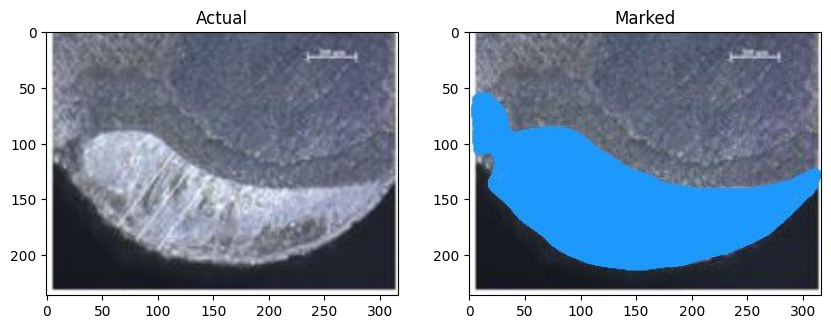

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im1=cv2.imread(simple_f[9])
im2=cv2.imread(marked_f[9])
axs[0].imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
axs[0].set_title('Actual')
axs[1].imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
axs[1].set_title('Marked')

### Segmentation
Creating the function for segmentation

In [ ]:
def segm(image):
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  histogram = cv2.calcHist([gray_image], [0], None, [256], [0, 256])

  # this is set according to the color used to calcuate the difference
  lower_threshold = 126
  upper_threshold = 128

 
  _, threshold_lower = cv2.threshold(gray_image, lower_threshold, 255, cv2.THRESH_BINARY)
  _, threshold_upper = cv2.threshold(gray_image, upper_threshold, 255, cv2.THRESH_BINARY_INV)
  segmented_image = cv2.bitwise_and(threshold_lower, threshold_upper)
  denoised_image = cv2.medianBlur(segmented_image, 5)
  return denoised_image


### Testing the methodology
1. Enter the value between 65 and 130
2. First the nearest upper and lower bound image will be taken.
3. Then they will be segmented
4. The images will be shifted to occupy maximum area
5. Interpolation showing the growth will be plotted

 Enter the value below

In [ ]:
value_of_frame=79# change this value below between 65 and 130

###***********DO NOT MAKE ANY CHANGE BELOW THIS*********************
lower_val=max(65,5*int(value_of_frame/5) )
upper_val=min(130,5*int(value_of_frame/5)+5 )
assert (lower_val<=upper_val),"The input value is incorrect"
if value_of_frame%5==0:
  upper_val=lower_val

There are three parts to this image:
1.  The pure white area represents the previous image
2.  The medium part represents the growth which has progressed since then
3.  The ligher part has area which was not covered in this but is part of the target image i.e the upper bound image


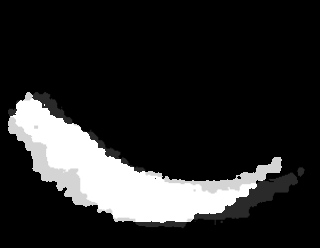

In [ ]:
#Taking input from the folder
imi1=cv2.imread(('/content/Crater_Wear-Edited/'+str(lower_val)+' m_min.jpg'))
imi2=cv2.imread(('/content/Crater_Wear-Edited/'+str(upper_val)+' m_min.jpg'))



#**************Finding the segmented parts*******************************
image1=segm(imi1)
image2=segm(imi2)
#resizing image 2 to fit image 1
image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]))



#***********************Shifting the images to overlap maximum area**************************
contours1, _ = cv2.findContours(image1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour1 = max(contours1, key=cv2.contourArea)
x1, y1, w1, h1 = cv2.boundingRect(contour1)
contours2, _ = cv2.findContours(image2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour2 = max(contours2, key=cv2.contourArea)
x2, y2, w2, h2 = cv2.boundingRect(contour2)
shift_x = x1 - x2
shift_y = y1 - y2
M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
shifted_image2 = cv2.warpAffine(image2, M, (image1.shape[1], image1.shape[0]))


print("There are three parts to this image:")
print("1.  The pure white area represents the previous image")
print("2.  The medium part represents the growth which has progressed since then")
print("3.  The ligher part has area which was not covered in this but is part of the target image i.e the upper bound image")


#********************************Use of interpolation to mark the specific targets*******************

image1 = cv2.resize(image1, (shifted_image2.shape[1], shifted_image2.shape[0]))
num_intermediate_images = 5  # this is set such that every image obtained is of integer this can be adjusted accordingly
# Loop through and create intermediate images
for i in range(1, num_intermediate_images + 1):
    alpha = i / (num_intermediate_images + 1) # Interpolation factor
    intermediate_image = cv2.addWeighted(image1, 1 - alpha, shifted_image2, alpha, 0)
    if i+lower_val==upper_val:
      cv2_imshow(intermediate_image)
    cv2.waitKey(0)
if lower_val==upper_val:
  cv2_imshow(image1)
cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np
import zipfile

def segm(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    histogram = cv2.calcHist([gray_image], [0], None, [256], [0, 256])

    # this is set according to the color used to calculate the difference
    lower_threshold = 126
    upper_threshold = 128

    _, threshold_lower = cv2.threshold(gray_image, lower_threshold, 255, cv2.THRESH_BINARY)
    _, threshold_upper = cv2.threshold(gray_image, upper_threshold, 255, cv2.THRESH_BINARY_INV)
    segmented_image = cv2.bitwise_and(threshold_lower, threshold_upper)
    denoised_image = cv2.medianBlur(segmented_image, 5)

    # Calculate the area of the colored part
    area = cv2.countNonZero(denoised_image)

    return denoised_image, area

# Load the zip file
zip_file = zipfile.ZipFile("Crater_Wear-Edited.zip")

# Loop over all files in the zip file
for filename in zip_file.namelist():
    # Check if the file is an image
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Read the image from the zip file
        with zip_file.open(filename) as file:
            image = cv2.imdecode(np.frombuffer(file.read(), np.uint8), -1)

            # Segment the image and calculate the area of the colored part
            segmented_image, area = segm(image)

            # If area is zero, print a message
            if area == 0:
                print(f"Image: {filename}, Pixel is not clear enough to predict area")
            else:
                # Print the area
                print(f"Image: {filename}, Area: {area}")


Image: Crater_Wear-Editted/100 m_min.jpg, Area: 14708
Image: Crater_Wear-Editted/105 m_min.jpg, Area: 15840
Image: Crater_Wear-Editted/110 m_min.jpg, Area: 13802
Image: Crater_Wear-Editted/115 m_min.jpg, Area: 18012
Image: Crater_Wear-Editted/120 m_min.jpg, Area: 16613
Image: Crater_Wear-Editted/125 m_min.jpg, Area: 18445
Image: Crater_Wear-Editted/130 m_min.jpg, Area: 19640
Image: Crater_Wear-Editted/55 m_min.jpg, Pixel is not clear enough to predict area
Image: Crater_Wear-Editted/60 m_min.jpg, Pixel is not clear enough to predict area
Image: Crater_Wear-Editted/65 m_min.jpg, Area: 15084
Image: Crater_Wear-Editted/70 m_min.jpg, Area: 11260
Image: Crater_Wear-Editted/75 m_min.jpg, Area: 11449
Image: Crater_Wear-Editted/80 m_min.jpg, Area: 12579
Image: Crater_Wear-Editted/85 m_min.jpg, Area: 13051
Image: Crater_Wear-Editted/90 m_min.jpg, Area: 16053
Image: Crater_Wear-Editted/95 m_min.jpg, Area: 14361


In [ ]:
#Taking input from the folder
imi1=cv2.imread(('/content/Crater_Wear-Edited/'+str(lower_val)+' m_min.jpg'))
imi2=cv2.imread(('/content/Crater_Wear-Edited/'+str(upper_val)+' m_min.jpg'))

#**************Finding the segmented parts*******************************
image1=segm(imi1)
image2=segm(imi2)
#resizing image 2 to fit image 1
image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]))

#***********************Shifting the images to overlap maximum area**************************
contours1, _ = cv2.findContours(image1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour1 = max(contours1, key=cv2.contourArea)
x1, y1, w1, h1 = cv2.boundingRect(contour1)
contours2, _ = cv2.findContours(image2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour2 = max(contours2, key=cv2.contourArea)
x2, y2, w2, h2 = cv2.boundingRect(contour2)
shift_x = x1 - x2
shift_y = y1 - y2
M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
shifted_image2 = cv2.warpAffine(image2, M, (image1.shape[1], image1.shape[0]))

print("There are three parts to this image:")
print("1.  The pure white area represents the previous image")
print("2.  The medium part represents the growth which has progressed since then")
print("3.  The ligher part has area which was not covered in this but is part of the target image i.e the upper bound image")

#********************************Use of interpolation to mark the specific targets*******************

image1 = cv2.resize(image1, (shifted_image2.shape[1], shifted_image2.shape[0]))
num_intermediate_images = 5  # this is set such that every image obtained is of integer this can be adjusted accordingly

total_area = 0.0
# Loop through and create intermediate images
for i in range(1, num_intermediate_images + 1):
    alpha = i / (num_intermediate_images + 1) # Interpolation factor
    intermediate_image = cv2.addWeighted(image1, 1 - alpha, shifted_image2, alpha, 0)
    if i+lower_val==upper_val:
        cv2_imshow(intermediate_image)
    cv2.waitKey(0)
    contours, _ = cv2.findContours(intermediate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(contour)
    total_area += area
    
if lower_val==upper_val:
    cv2_imshow(image1)
    contours, _ = cv2.findContours(image1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(contour)
    total_area += area
    
print("Total area of the image is:", total_area)
cv2.destroyAllWindows()


There are three parts to this image:
1.  The pure white area represents the previous image
2.  The medium part represents the growth which has progressed since then
3.  The ligher part has area which was not covered in this but is part of the target image i.e the upper bound image
Total area of the image is: 69710.0


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Load the dataset from the Excel file
df = pd.read_excel("Input.xlsx")

# Fit a linear regression model to the given dataset
model = LinearRegression()
model.fit(df[['Cutting Speed (m/min)']], df[['TOTAL AREA (At)']])

# Predict the area for an intermediate velocity of v m/min
predicted_area = model.predict([[97]])

print("Predicted area for intermediate velocity of V m/min:", predicted_area[0][0])


Predicted area for intermediate velocity of V m/min: 352859.03690441174


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
